In [ ]:
#| default_exp scoring

# Scorer
The Scorer abstract class defines the interface for implementations that calculate scores for each possible pairing between sets of response units and of target items. Example concrete implementations of this class can utilize methods such as keyword matching, similarity measures, or machine learning algorithms.

In [ ]:
#| export
from abc import ABC, abstractmethod
from typing import List, Union, Dict
import numpy as np


class Scorer(ABC):

    """
    Abstract base class for implementing scoring strategies.
    To create a custom scorer, inherit from this class and
    override the score method.
    """

    @abstractmethod
    def __call__(self, 
               response_units: Union[List[str], List[Dict[str, object]]], 
               target_items: Union[List[str], List[Dict[str, object]]],
               response_context: str, target_context: str) -> np.ndarray:
        """
        Matches the response_units to target_items based on a specific strategy.

        Args:
            response_units (Union[List[str], List[Dict[str, object]]]): List of response units. 
                Each response unit can be a string or a dictionary (when both text and spans are available).

            target_items (Union[List[str], List[Dict[str, object]]]): List of target items. 
                Each response unit can be a string or a dictionary (when both text and spans are available).

            response_context (str): The context of the response units.
            target_context (str): The context of the target items.

        Returns:
            np.ndarray: A 2D numpy array containing the scores for each possible pairing.
        """
        pass

## SentenceTransformer Scorer
The SentenceTransformer Matcher is a concrete implementation of the Matcher class that uses a similarity measure drawn from the pretrained embedding models accessible via `SentenceTransformer` module of the `sentence_transformers` library. The similarity measure used is the cosine similarity between the embedding vectors retrieved for the response unit and for the target item.

In [ ]:
#|export

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from typing import List

class SentenceTransformerScorer(Scorer):
    """
    Concrete Scorer class that computes similarity scores between response units
    and target items using a SentenceTransformers model. The cosine similarity
    between sentence embeddings is used as the similarity metric.
    """

    def __init__(self, model_name: str):
        """
        Initializes the SentenceTransformerScorer with a specified model.

        Args:
            model_name (str): Name of the SentenceTransformers model.
        """
        self.model = SentenceTransformer(model_name)

    def __call__(self, 
               response_units: Union[List[str], List[Dict[str, object]]], 
               target_items: Union[List[str], List[Dict[str, object]]],
               response_context: str = '', target_context: str = '') -> np.ndarray:
        """
        Matches the response_units to target_items based on a specific strategy.

        Args:
            response_units (Union[List[str], List[Dict[str, object]]]): List of response units. 
                Each response unit can be a string or a dictionary (when both text and spans are available).

            target_items (Union[List[str], List[Dict[str, object]]]): List of target items. 
                Each response unit can be a string or a dictionary (when both text and spans are available).

            response_context (str): The context of the response units. Unused.
            target_context (str): The context of the target items. Unused.

        Returns:
            np.ndarray: A 2D numpy array containing the scores for each possible pairing.
        """

        if isinstance(response_units[0], dict):
            response_units = [unit["text"] for unit in response_units]
        if isinstance(target_items[0], dict):
            target_items = [item["text"] for item in target_items]

        embeddings = self.model.encode(response_units + target_items)
        response_embeddings = np.array(embeddings[:len(response_units)])
        target_embeddings = np.array(embeddings[len(response_units):])
        scores_matrix = cosine_similarity(target_embeddings, response_embeddings)
        return scores_matrix


## Generic Cross Encoder Scorer
The `sentence_transformer` library also hosts pretrained Cross-Encoders. Cross-Encoders require the input of a text pair and output a score 0...1. They do not work for individual sentences and they don't compute embeddings for individual texts.

Since outputs are generated only per pairing, Cross Encoders tend to work more slowly than embedding-based comparison approaches, which only have to be generated once per text. However, they tend to be more accurate.

In [ ]:
#| export
from sentence_transformers import CrossEncoder
from itertools import product

class CrossEncoderScorer(Scorer):
    """
    Concrete Scorer class that computes similarity scores between response units
    and target items using a SentenceTransformers model. The cosine similarity
    between sentence embeddings is used as the similarity metric.
    """

    def __init__(self, model_name: str):
        """
        Initializes the SentenceTransformerScorer with a specified model.

        Args:
            model_name (str): Name of the CrossEncoder model.
        """
        self.model = CrossEncoder(model_name)

    def __call__(self, 
               response_units: Union[List[str], List[Dict[str, object]]], 
               target_items: Union[List[str], List[Dict[str, object]]],
               response_context: str = '', target_context: str = '') -> np.ndarray:
        """
        Matches the response_units to target_items based on a specific strategy.

        Args:
            response_units (Union[List[str], List[Dict[str, object]]]): List of response units. 
                Each response unit can be a string or a dictionary (when both text and spans are available).

            target_items (Union[List[str], List[Dict[str, object]]]): List of target items. 
                Each response unit can be a string or a dictionary (when both text and spans are available).

            response_context (str): The context of the response units. Unused.
            target_context (str): The context of the target items. Unused.

        Returns:
            np.ndarray: A 2D numpy array containing the scores for each possible pairing.
        """
        if isinstance(response_units[0], dict):
            response_units = [unit["text"] for unit in response_units]
        if isinstance(target_items[0], dict):
            target_items = [item["text"] for item in target_items]
            
        pairs = list(product(target_items, response_units))
        pair_scores = self.model.predict(pairs)
        scores_matrix = np.array([pair_scores[i:i + len(response_units)] for i in range(
            0, len(pair_scores), len(response_units))])
        return scores_matrix

## Contextualized Embedding Scorer

In [ ]:
#| export

from response_sequencer.utilities import find_sublist_indices
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
from typing import List, Optional, Tuple

def find_overlapping_indices(spans: List[Tuple[int, int]], offset_mapping: List[Tuple[int, int]]) -> List[int]:
    overlapping_indices = []
    
    for span_start, span_end in spans:
        # Iterate through the offset_mapping and compare each span
        for idx, (offset_start, offset_end) in enumerate(offset_mapping):
            # Check if the span and the offset_mapping overlap
            if span_start < offset_end and offset_start < span_end:
                # Overlapping span found, add its index to the result
                overlapping_indices.append(idx)
                
    return overlapping_indices

class ContextualizedEmbeddingScorer(Scorer):
    """
    Cosine similarity over contextualized sentence embeddings loaded using the transformers library.
    """

    def __init__(self, model_name: str = "bert-base-cased", layer_depth: int = 1):
        """
        Initializes the ContextualizedEmbeddingScorer with a specified
        response_context, model_name, and layer selection.

        Args:
            model_name (str): Name of the SentenceTransformers model.
            layers (Optional[List[int]]): A list of layer indices to use for contextualized embedding.
        """

        self.layers = list(range(-layer_depth, 0))
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name, output_hidden_states=True)

    def __call__(self, 
               response_units: Union[List[str], List[Dict[str, object]]], 
               target_items: Union[List[str], List[Dict[str, object]]],
               response_context: str, target_context: str = '') -> np.ndarray:
        """
        Matches the response_units to target_items based on a specific strategy.

        Args:
            response_units (Union[List[str], List[Dict[str, object]]]): List of response units. 
                Each response unit can be a string or a dictionary (when both text and spans are available).

            target_items (Union[List[str], List[Dict[str, object]]]): List of target items. 
                Each response unit can be a string or a dictionary (when both text and spans are available).

            response_context (str): The context of the response units. Unused.
            target_context (str): The context of the target items. Unused.

        Returns:
            np.ndarray: A 2D numpy array containing the scores for each possible pairing.
        """

        # if target context exists, use it to generate embeddings for all target items
        if target_context:
            self.target_tokens = self.tokenizer.tokenize(target_context)        
            self.target_embeddings, self.encoded_target = self._all_token_embeddings(target_context)
            target_embeddings = np.array([
                self._unit_embedding(
                item, self.target_tokens, self.encoded_target, self.target_embeddings
                    ) for item in target_items])
            
        # otherwise use each target item itself as their own context
        else:
            target_embeddings = []
            for item in target_items:
                if isinstance(item, dict):
                    item = item["text"]
                self.target_tokens = self.tokenizer.tokenize(item)
                self.target_embeddings, self.encoded_target = self._all_token_embeddings(item)
                target_embeddings.append(self._unit_embedding(
                    item, self.target_tokens, self.encoded_target, self.target_embeddings
                ))
            target_embeddings = np.array(target_embeddings)

        self.response_tokens = self.tokenizer.tokenize(response_context)
        self.response_embeddings, self.encoded_response = self._all_token_embeddings(response_context)
        response_embeddings = np.array([
            self._unit_embedding(
            unit, self.response_tokens, self.encoded_response, self.response_embeddings
            ) for unit in response_units])
        # response_embeddings = []
        # for unit in response_units:
        #     if isinstance(unit, dict):
        #         unit = unit["text"]
        #     self.response_tokens = self.tokenizer.tokenize(unit)
        #     self.response_states, self.encoded_response = self._get_context_states(unit)
        #     response_embeddings.append(self._contextualized_unit_embedding(
        #         unit, self.response_tokens, self.encoded_response, self.response_states
        #     ))
        # response_embeddings = np.array(response_embeddings)

        return cosine_similarity(target_embeddings, response_embeddings)

    def _all_token_embeddings(self, context: str):
        """
        Encodes the specified context and generates all corresponding token embeddings.

        Args:
            context (str): The text context for which the hidden states are required.
        """

        with torch.no_grad():
            encoded_context = self.tokenizer(context, return_tensors="pt", return_offsets_mapping=True)
            output = self.model(
                input_ids=encoded_context["input_ids"], 
                #token_type_ids=encoded_context["token_type_ids"], 
                attention_mask=encoded_context["attention_mask"])
        
        token_embeddings = torch.stack(
            [output.hidden_states[i] for i in self.layers]).sum(0).squeeze()
        return token_embeddings, encoded_context
    
    def _unit_embedding(
            self, unit: Union[List[str], List[Dict[str, object]]],
            tokens: List[str], encoded_context, token_embeddings) -> np.ndarray:
        """
        Pools an embedding for the tokens associated with a specified unit.

        Args:
            unit (str): The text unit to be encoded (either response or target unit).
            tokens (List[str]): A list of tokens corresponding to the context.
            encoded_context: The encoded context.
            token_embeddings: token_embeddings associated with encoded context
        """

        if isinstance(unit, dict):
            token_indices = find_overlapping_indices(
                unit["spans"], encoded_context["offset_mapping"][0][1:-1])
            embeddings = token_embeddings[token_indices]
            if np.isnan(embeddings.numpy()).any():
                raise ValueError("The unit spans are not valid.")
        else:
            embeddings = []
            unit_tokens = self.tokenizer.tokenize(unit)
            unit_start_indices = find_sublist_indices(tokens, unit_tokens)
            for start_idx in unit_start_indices:
                start_idx += 1 # Ignore the [CLS] token
                end_idx = start_idx + len(unit_tokens) 
                embeddings.append(token_embeddings[start_idx:end_idx].mean(dim=0).numpy())

        return np.mean(np.array(embeddings), axis=0)

In [ ]:
from response_sequencer.datasets import SensesDataset
from response_sequencer.segmenting import MultiSentenceFragmentsSegmenter
from response_sequencer.evaluating import JaccardScoreSegmenterEvaluator, SegmentMatcherEvaluator
from response_sequencer.matching import MaximumScoreMatcher
from response_sequencer.sequencing import PipelineSequencer
import os



In [ ]:
section_tag = 'base' # unique identifier for this variation of notebook parameters
output_dir = '../data/'

dataset = SensesDataset(
    os.path.join(output_dir, f'{section_tag}_senses.h5'), 
    os.path.join(output_dir, f'{section_tag}_sense_pool.txt'))

segmenter = MultiSentenceFragmentsSegmenter(max_sentences=1, min_tokens=4)
evaluator = SegmentMatcherEvaluator(JaccardScoreSegmenterEvaluator(), only_matched=True)
trial_index = 0
trial = dataset[trial_index]


scores = []
for layer_depth in [10]:#range(1, 25):
    scorer = ContextualizedEmbeddingScorer(model_name='intfloat/e5-large', layer_depth=layer_depth)
    matcher = MaximumScoreMatcher(scorer)
    sequencer = PipelineSequencer(segmenter, matcher)
    result = sequencer(trial['response_transcript'], trial['target_items'])


    typical_result = evaluator(
        trial['response_transcript'], trial['response_units'], result['response_units'], 
        trial['matches'], result['matches'])
    scores.append(typical_result)

# perfect_result = evaluator(
#     trial['response_transcript'], trial['response_units'], trial['response_units'],
#     trial['matches'], trial['matches'])

# typical_result, perfect_result

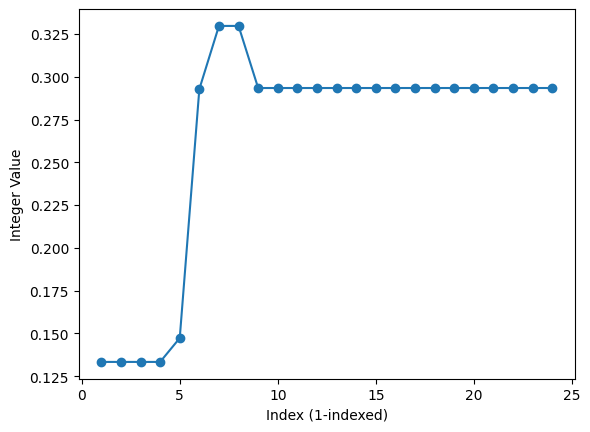

In [ ]:
import matplotlib.pyplot as plt



In [ ]:
def plot_integers(int_list):
    # Create the x-axis values (1-indexed positions)
    x_values = [i + 1 for i in range(len(int_list))]
    
    # Create the y-axis values (integers from the list)
    y_values = int_list
    
    # Plot the integers
    plt.plot(x_values, y_values, marker='o')
    
    # Label the axes
    plt.xlabel('Index (1-indexed)')
    plt.ylabel('Integer Value')
    
    # Show the plot
    plt.show()

plot_integers(scores)

In [ ]:
from response_sequencer.segmenting import SentenceSegmenter

In [ ]:
segmenter = SentenceSegmenter()

response_transcript_1 = "Apples are a type of fruit. I really like them. They are red in color."
response_transcript_2 = "Roses are a type of flower. I really like them. They are red in color."
response_transcript_3 = "Apples are a type of fruit. I really like them."
response_transcript_4 = "Roses are a type of flower. I really like them."
target_items = ["Roses are red"]

# scorer = ContextualizedEmbeddingScorer(model_name='intfloat/e5-large', layer_depth=9)
# scorer = ContextualizedEmbeddingScorer(
#     model_name='sentence-transformers/paraphrase-multilingual-mpnet-base-v2', layer_depth=1)
segmenter(response_transcript_1)

In [ ]:
response_transcript_base = 'Is this really okay?'
scorer = SentenceTransformerScorer(
    model_name='sentence-transformers/all-mpnet-base-v2')
scorer(segmenter(response_transcript_base), target_items, response_transcript_base)

array([[0.09639319]], dtype=float32)

In [ ]:
scorer = ContextualizedEmbeddingScorer(
    model_name='sentence-transformers/all-mpnet-base-v2', layer_depth=1)
scorer(segmenter(response_transcript_base), target_items, response_transcript_base)

array([[0.11344098]], dtype=float32)

In [ ]:
scorer(segmenter(response_transcript_1), target_items, response_transcript_1)

array([[0.3340314 , 0.2874723 , 0.37109596]], dtype=float32)

In [ ]:
scorer(segmenter(response_transcript_2), target_items, response_transcript_2)

array([[0.7060834 , 0.61133194, 0.66966313]], dtype=float32)

In [ ]:
scorer(segmenter(response_transcript_3), target_items, response_transcript_3)

array([[0.25388408, 0.21075514]], dtype=float32)

In [ ]:
scorer(segmenter(response_transcript_4), target_items, response_transcript_4)

array([[0.6529485, 0.5501174]], dtype=float32)

## OpenAI Embedding Scorer
Unfinished. Currently free embedding options are around as good.

In [ ]:
import requests
from typing import Tuple

In [ ]:
class OpenAIEmbeddingScorer(Scorer):
    """
    Scorer that calculates similarity scores between response_units and target_items
    using OpenAI's text embeddings.
    """

    def __init__(self, api_key: str, model: str = "text-embedding-ada-002"):
        """
        Args:
            api_key (str): Your OpenAI API key.
            api_url (str, optional): URL for OpenAI's semantic search API.
        """
        self.api_key = api_key
        self.model = api_url

    def __call__(self, 
               response_units: Union[List[str], List[Dict[str, object]]], 
               target_items: Union[List[str], List[Dict[str, object]]],
               response_context: str = '', target_context: str = '') -> np.ndarray:
        """
        Matches the response_units to target_items based on a specific strategy.

        Args:
            response_units (Union[List[str], List[Dict[str, object]]]): List of response units. 
                Each response unit can be a string or a dictionary (when both text and spans are available).

            target_items (Union[List[str], List[Dict[str, object]]]): List of target items. 
                Each response unit can be a string or a dictionary (when both text and spans are available).

            response_context (str): The context of the response units. Unused.
            target_context (str): The context of the target items. Unused.

        Returns:
            np.ndarray: A 2D numpy array containing the scores for each possible pairing.
        """
        
        embeddings = self.get_embeddings(response_units + target_items)
        response_embeddings = embeddings[:len(response_units)]
        target_embeddings = embeddings[len(response_units):]

        scores = np.inner(response_embeddings, target_embeddings)
        return scores

    def get_embeddings(self, texts: List[Union[str, Dict[str, object]]]) -> np.ndarray:
        """
        Retrieves embeddings for the given texts from OpenAI's API.

        Args:
            texts (List[Union[str, Dict[str, object]]]): List of texts or text-spans dictionaries.

        Returns:
            np.ndarray: A 2D numpy array containing the embeddings for each text.
        """
        prompt_strings = [text["text"] if isinstance(text, dict) else text for text in texts]
        data = {
            "api_key": self.api_key,
            "prompts": prompt_strings,
            "n": len(prompt_strings)
        }

        response = requests.post(self.api_url, json=data)
        response.raise_for_status()
        embeddings = np.array([result["embedding"] for result in response.json()["data"]])

        return embeddings


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()